# Conditional Poisson Distribution and Multinomial Distribution

This notebook demonstrates how to compute the conditional probability of independent Poisson-distributed variables given their sum, resulting in a multinomial distribution. We use JAX for efficient computation.

## Imports and Configuration
First, we import the necessary libraries and configure JAX to use 64-bit precision.


In [16]:
from jax import vmap, jit, config
import jax.numpy as jnp
import jax.scipy.stats as jst
import matplotlib.pyplot as plt
from functools import partial 
config.update("jax_enable_x64", True)


## Define Functions

We define the function `conditional_poisson_prob` to compute the conditional probability. The `prob` function computes the probability parameter for the binomial distribution.


In [8]:
def conditional_poisson_prob(r: int, S: int):
    sum_over_r = jnp.arange(0, S + 1)

    def process(mu1, mu2):
        # Joint probability of the Poisson distributions
        poisson_joint_prob = lambda r: jst.poisson.pmf(k=r, mu=mu1) * jst.poisson.pmf(k=S - r, mu=mu2)
        vectorized_poisson_joint_prob = vmap(poisson_joint_prob)
        
        # Normalization constant for the conditional distribution
        normalization_constant = jnp.sum(vectorized_poisson_joint_prob(sum_over_r))
        
        # Joint probability for given r
        joint_poisson_prob = jst.poisson.pmf(k=r, mu=mu1) * jst.poisson.pmf(k=S - r, mu=mu2)
        
        return joint_poisson_prob / normalization_constant

    return jit(process)

def prob(mu1, mu2):
    return mu1 / (mu1 + mu2)


## Mathematical Background

Given independent Poisson-distributed variables $X_1, X_2, \ldots, X_n$ with parameters $\mu_1, \mu_2, \ldots, \mu_n$, the sum $S=X_1+X_2+\ldots+X_n$ follows a Poisson distribution with parameter $\sigma=\sum_{j=1}^n \mu_j$

The conditional probability of $X_1=r_1, X_2=r_2, \ldots, X_n=r_n$ given $S=s$ is:
$$
P\left(X_1=r_1, X_2=r_2, \ldots, X_n=r_n \mid S=s\right)=\frac{P\left(X_1=r_1\right) \cdot P\left(X_2=r_2\right) \cdot \ldots \cdot P\left(X_n=r_n\right)}{P(S=s)}
$$

Since each $X_j$ follows a Poisson distribution:
$$
P\left(X_j=r_j\right)=\frac{\mu_j^{r_j} e^{-\mu_j}}{r_{j}!}
$$

The joint probability is:
$$
P\left(X_1=r_1, X_2=r_2, \ldots, X_n=r_n \mid S=s\right)=\frac{\prod_{j=1}^n \frac{\mu_j^{r_j} e^{-\mu_j}}{r_{j}!}}{\frac{\sigma^s e^{-\sigma}}{s!}}
$$

Simplifying, we get the multinomial distribution with parameters $p_j=\frac{\mu_j}{\sigma}$ :
$$
P\left(X_1=r_1, X_2=r_2, \ldots, X_n=r_n \mid S=s\right)=\frac{s!}{r_1! r_2! \ldots r_n!} \prod_{j=1}^n \left( \frac{\mu_j}{\sigma} \right)^{r_j}
$$

In the special case of $n=2$, this reduces to a binomial distribution:
$$
P(X=r \mid X+Y=s)=\binom{s}{r} p^r (1-p)^{s-r}
$$
where $p = \frac{\mathbb{E}[X]}{\mathbb{E}[X] + \mathbb{E}[Y]} = \frac{\mu_1}{\mu_1 + \mu_2}$


## Parameters

Set the parameters for the computation: the total sum $S$, the means of the Poisson distributions $\mu_1$ and $\mu_2$, and the range of $r$ values.


In [27]:
# Parameters
S = 60
mus = (1, 1)
r_values = jnp.arange(0, S + 1)


## Vectorized Computation

We create a vectorized version of the `conditional_poisson_prob` function and compute the results.


In [28]:
# Vectorized version
experiment = lambda r: conditional_poisson_prob(r, S)(*mus)
V_version = vmap(experiment)


In [29]:
# Compute results
res = V_version(r_values)
binom = jst.binom.pmf(p=prob(*mus), k=r_values, n=S)

## Plot the Results

We plot the computed results and the binomial probability mass function (PMF) for comparison.


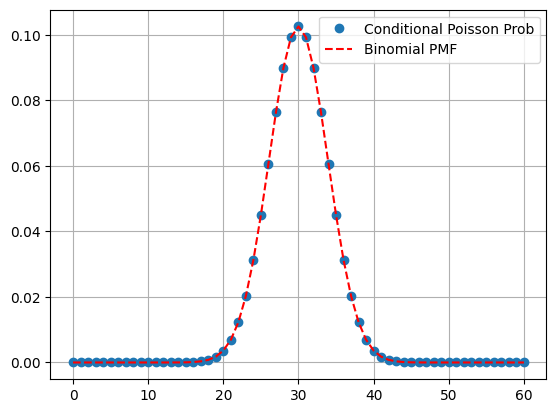

In [30]:
# Plot the results
plt.plot(r_values, res, "o", label="Conditional Poisson Prob")
plt.plot(r_values, binom, "r--", label="Binomial PMF")
plt.grid(True)
plt.legend()
plt.show()


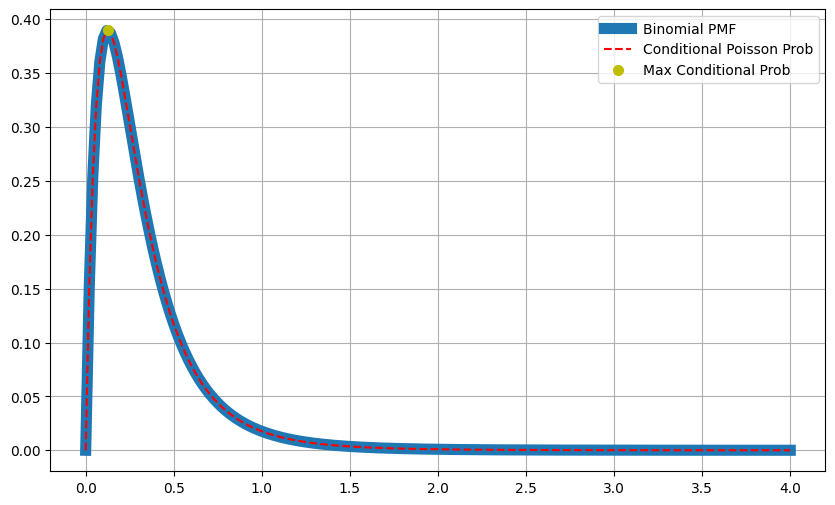

In [19]:
# Vectorized probability calculation
vectorized_probability = vmap(
    fun=partial(prob, mu2=1)
)

r = 1
mu1 = jnp.linspace(0, 4, 200)
mu2 = 1
n = 9

# Partial function for binomial probability mass function
partial_binomial_pmf = lambda prob: partial(
    jst.binom.pmf,
    k=r,
    n=n,
    loc=0
)(p=prob)

# Vectorized binomial PMF calculation
vectorized_binomial_pmf = vmap(
    fun=partial_binomial_pmf
)

# Calculate probabilities and binomial results
probabilities = vectorized_probability(mu1)
binomial_results = vectorized_binomial_pmf(probabilities)

# Partial function for conditional Poisson probability
partial_conditional_prob = partial(conditional_poisson_prob(r, n), mu2=1)

# Vectorized conditional Poisson probability calculation
vectorized_conditional_prob = vmap(
    fun=partial_conditional_prob
)

# Calculate conditional probability results
conditional_prob_results = vectorized_conditional_prob(mu1)

# Function to compute maximum mu1
def compute_max_mu1(r1, r2, mu2):
    return jnp.array([r1 * mu2 / r2])

max_mu1_value = compute_max_mu1(r, n-r, mu2)
conditional_prob_max = vectorized_conditional_prob(max_mu1_value)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(mu1, binomial_results, linewidth=8, label='Binomial PMF')
plt.plot(mu1, conditional_prob_results, "--r", label='Conditional Poisson Prob')
plt.plot(max_mu1_value, conditional_prob_max, "yo", markersize=7, label='Max Conditional Prob')
plt.grid(True)
plt.legend()
plt.show()
